In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [2]:
dataset_path = r"D:\Deep Learning project\datatwo"
dataset_dir = pathlib.Path(dataset_path)

In [3]:
class_names = [item.name for item in dataset_dir.iterdir() if item.is_dir()]
print(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [4]:

train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 1570 files belonging to 7 classes.
Using 1256 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 1570 files belonging to 7 classes.
Using 314 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)
num_classes=len(class_names)

['algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


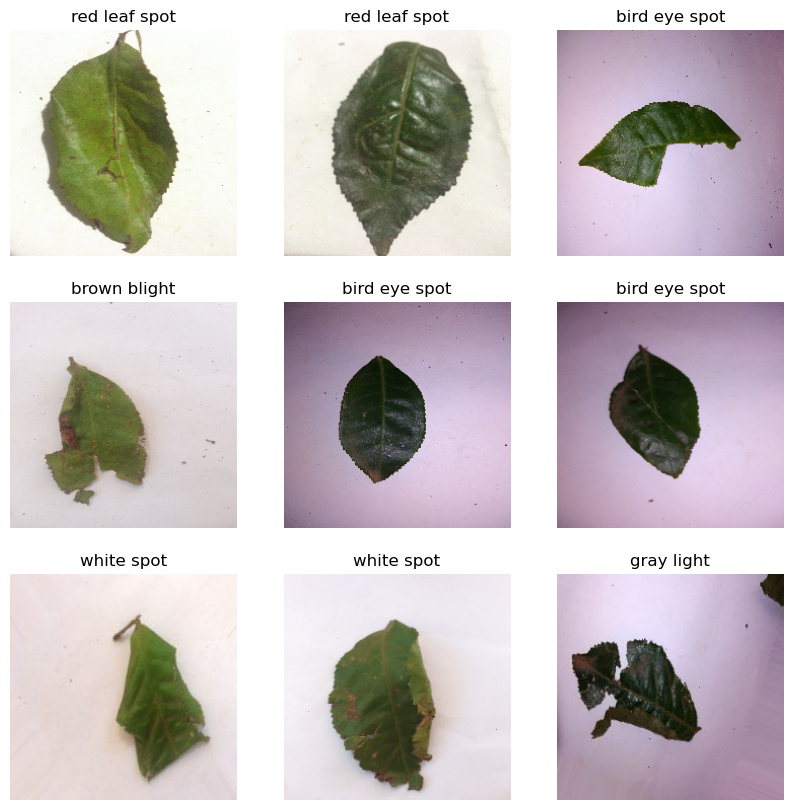

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [11]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(num_classes, activation='softmax')
])

In [12]:
base_learning_rate = 0.0005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                 

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)


In [15]:
epochs = 320
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/320



D:\Softwares\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



10/10 [==============================] - 49s 4s/step - loss: 2.0053 - accuracy: 0.1990 - val_loss: 1.9159 - val_accuracy: 0.1879
Epoch 2/320
10/10 [==============================] - 37s 4s/step - loss: 1.6917 - accuracy: 0.3209 - val_loss: 1.8960 - val_accuracy: 0.2739
Epoch 3/320
10/10 [==============================] - 38s 4s/step - loss: 1.4729 - accuracy: 0.3981 - val_loss: 1.8651 - val_accuracy: 0.2739
Epoch 4/320
10/10 [==============================] - 38s 4s/step - loss: 1.3694 - accuracy: 0.4275 - val_loss: 1.8445 - val_accuracy: 0.3599
Epoch 5/320
10/10 [==============================] - 38s 4s/step - loss: 1.2828 - accuracy: 0.4650 - val_loss: 1.8223 - val_accuracy: 0.3917
Epoch 6/320
10/10 [==============================] - 38s 4s/step - loss: 1.2222 - accuracy: 0.4944 - val_loss: 1.8050 - val_accuracy: 0.3599
Epoch 7/320
10/10 [==============================] - 38s 4s/step - loss: 1.1672 - accuracy: 0.5064 - val_loss: 1.7839 - val_accuracy: 0.3885
Epoch 8/320
10/10 [=====

10/10 [==============================] - 38s 4s/step - loss: 0.4286 - accuracy: 0.8352 - val_loss: 0.6787 - val_accuracy: 0.7229
Epoch 58/320
10/10 [==============================] - 38s 4s/step - loss: 0.4522 - accuracy: 0.8256 - val_loss: 0.5103 - val_accuracy: 0.7803
Epoch 59/320
10/10 [==============================] - 38s 4s/step - loss: 0.4238 - accuracy: 0.8463 - val_loss: 0.6695 - val_accuracy: 0.7038
Epoch 60/320
10/10 [==============================] - 38s 4s/step - loss: 0.4294 - accuracy: 0.8336 - val_loss: 0.5908 - val_accuracy: 0.7325
Epoch 61/320
10/10 [==============================] - 38s 4s/step - loss: 0.4117 - accuracy: 0.8392 - val_loss: 0.5321 - val_accuracy: 0.7452
Epoch 62/320
10/10 [==============================] - 38s 4s/step - loss: 0.4344 - accuracy: 0.8320 - val_loss: 0.5252 - val_accuracy: 0.7548
Epoch 63/320
10/10 [==============================] - 38s 4s/step - loss: 0.4293 - accuracy: 0.8264 - val_loss: 0.5596 - val_accuracy: 0.7325
Epoch 64/320
10/10 

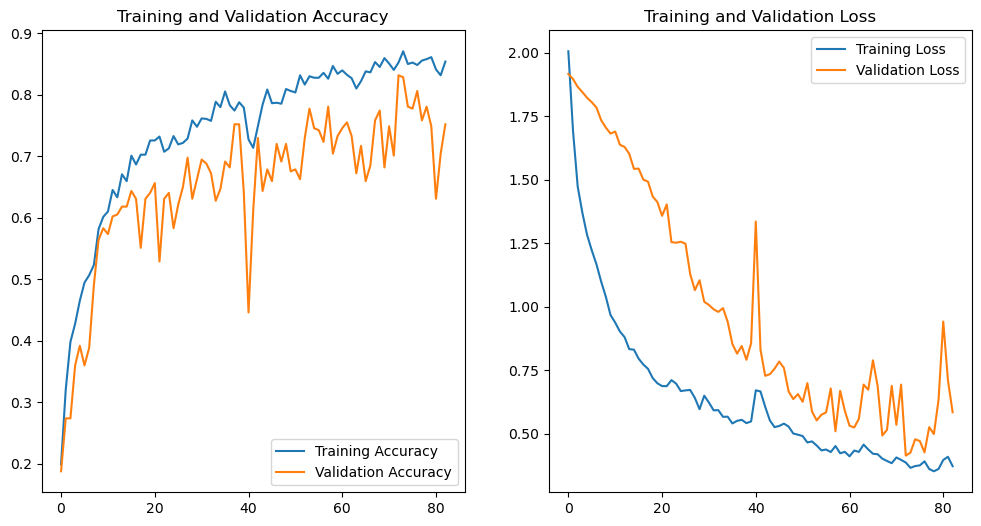

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

3/3 [==============================] - 2s 434ms/step


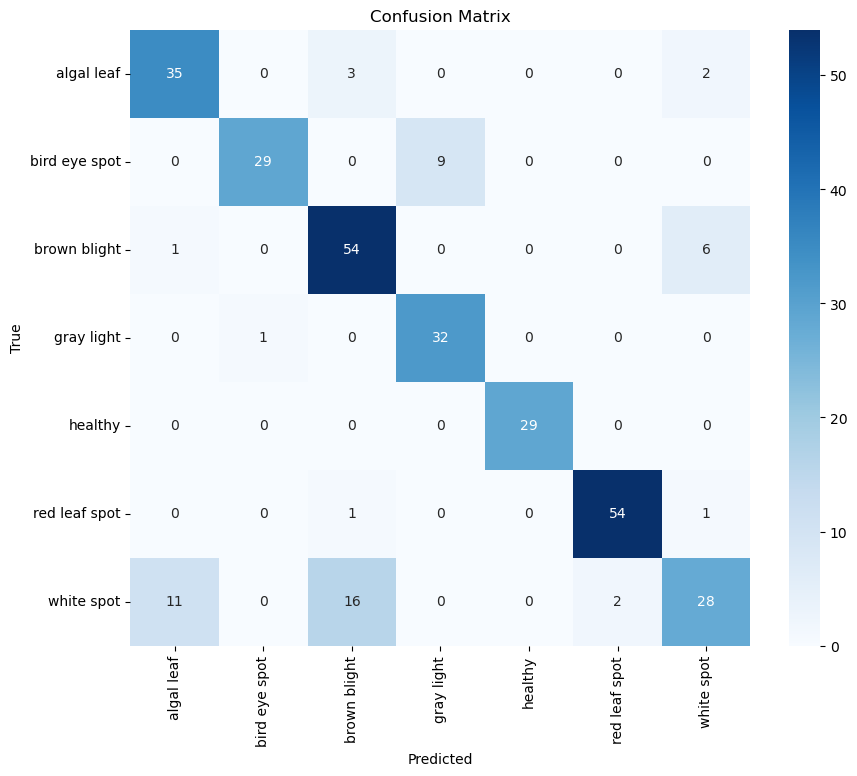

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


val_predictions = model.predict(val_ds)
val_predictions = np.argmax(val_predictions, axis=1)


true_labels = []
for _, labels in val_ds:
    true_labels.extend(labels.numpy())


conf_mat = confusion_matrix(true_labels, val_predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
model.save("D:\Deep Learning project/modelV3")

INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV3\assets


INFO:tensorflow:Assets written to: D:\Deep Learning project/modelV3\assets


Predictions:
 [2 0 4 2 0 2 3 4 1 3 1 2 5 5 2 5 0 5 4 6 6 6 3 2 5 2 4 5 3 0 1 2 2 5 2 5 1
 6 0 6 3 6 2 2 1 2 3 2 4 3 2 5 2 4 3 6 6 2 1 2 1 3 5 5 0 3 2 1 5 2 3 6 5 4
 2 6 3 1 5 5 3 4 2 2 5 0 1 3 3 3 5 5 3 0 2 2 1 0 0 3 4 3 5 0 2 5 6 2 2 3 4
 0 3 0 3 4 2 5 2 0 2 4 2 5 5 2 5 6]
Labels:
 [6 0 4 2 0 2 3 4 1 3 1 6 5 5 0 5 0 5 4 6 6 6 3 2 5 2 4 5 3 2 1 2 2 5 2 5 1
 6 6 6 1 5 2 6 1 2 3 6 4 3 2 5 2 4 3 6 6 2 1 2 1 3 5 5 0 3 2 1 5 2 3 6 5 4
 6 6 3 1 5 5 1 4 2 2 5 0 1 3 3 1 6 5 3 0 2 2 1 0 6 3 4 3 5 6 2 5 6 2 2 3 4
 0 3 0 3 4 2 5 6 0 2 4 6 6 5 2 5 2]

              precision    recall  f1-score   support

           0       0.71      0.91      0.80        11
           1       1.00      0.79      0.88        14
           2       0.76      0.93      0.83        27
           3       0.86      1.00      0.93        19
           4       1.00      1.00      1.00        12
           5       0.92      0.96      0.94        23
           6       0.83      0.45      0.59        22

    accuracy        

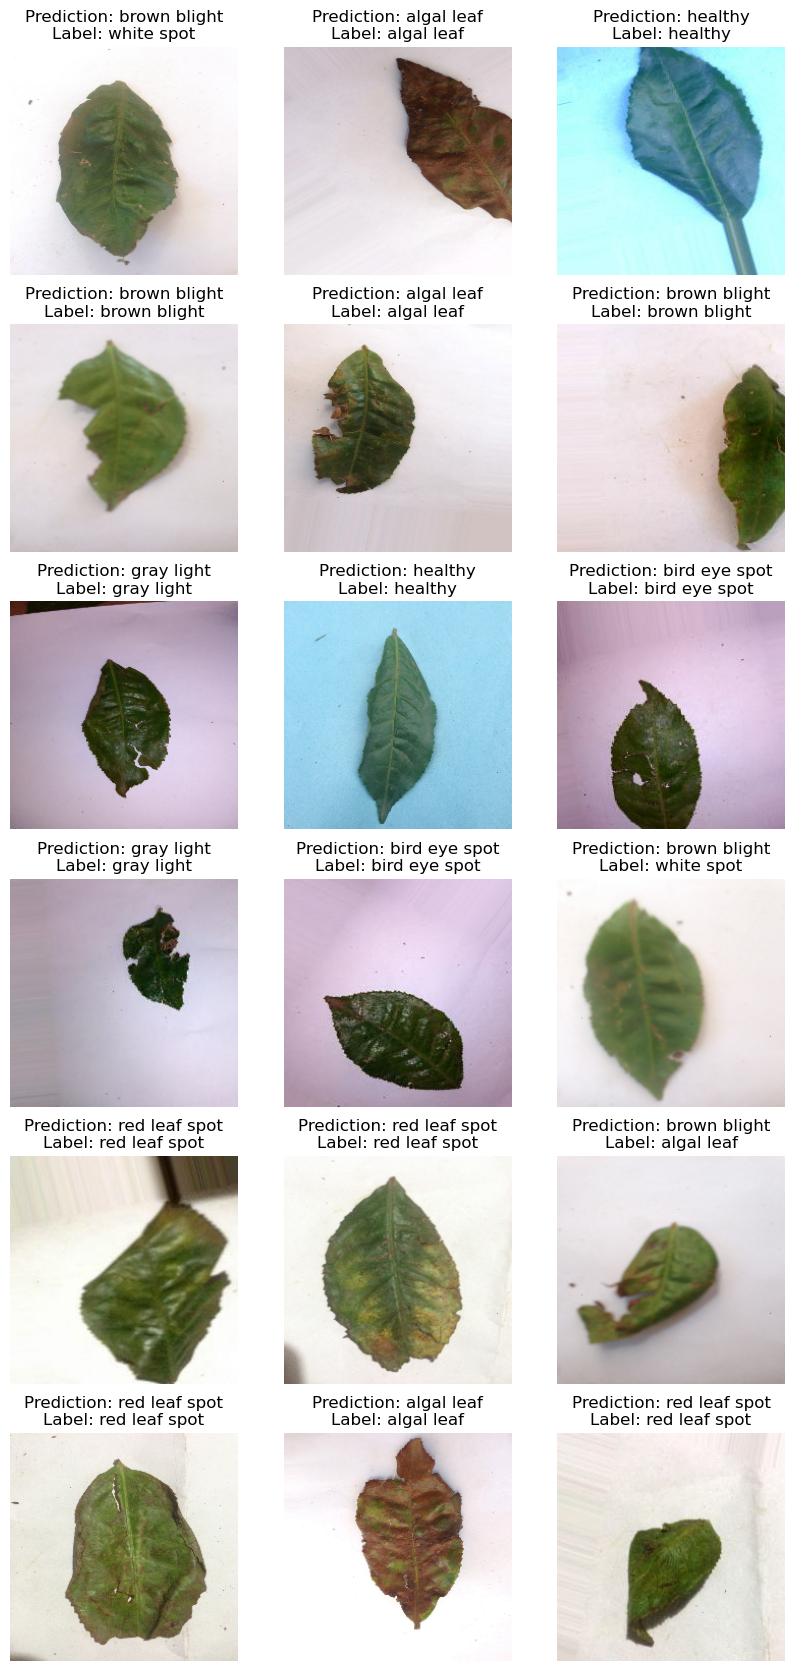

In [19]:

image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")